In [1]:
# python version 3.6.9 #
import pandas as pd # 1.1.5
import numpy as np # 1.19.5
import matplotlib.pyplot as plt
import matplotlib # 3.3.4
import scipy.stats as st # scipy 1.5.4
from matplotlib_venn import venn3, venn3_circles
import matplotlib.ticker as ticker
import seaborn as sns

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rc('text', usetex=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('source_data/included/figure.style')


In [2]:
combined = pd.read_csv('source_data/included/fig4_CRISPRi_enrichment.txt',sep='\t',index_col=0)
for rRNA_type in ['rrf','rrl','rrs']:
    LAG = combined.loc[(combined['LAGs'].str.contains(rRNA_type)) & (combined['LAGs'].str.contains('b'))].iloc[0,0]
    to_append = combined.loc[(combined['LAGs'].str.contains(rRNA_type)) & (combined['LAGs'].str.contains('b'))].groupby('strand').mean().reset_index()
    to_append.loc[:,to_append.columns.str.contains('signif')] = np.round(to_append.loc[:,to_append.columns.str.contains('signif')])
    to_append['LAGs'] = [LAG,LAG]
    combined = combined.loc[~((combined['LAGs'].str.contains(rRNA_type)) & (combined['LAGs'].str.contains('b')))]
    combined = combined.append(to_append)
    combined = combined.reset_index().drop('index',axis=1)

In [3]:
## define replicates for each sample type
metG_lag = ['SBC210_vs_SBC205','SBC101_vs_SBC96','SBC102_vs_SBC96','SBC100_vs_SBC96','SBC192_vs_SBC191']
MG1655_lag = ['SBC131_vs_SBC126','SBC132_vs_SBC126','SBC130_vs_SBC126']
metG_lag_abx = ['SBC207_vs_SBC210','SBC208_vs_SBC210','SBC209_vs_SBC210','SBC98_vs_SBC101','SBC99_vs_SBC101']
MG1655_lag_abx = ['SBC128_vs_SBC131','SBC129_vs_SBC131']
metG_exp = ['SBC212_vs_SBC211']
MG1655_exp = ['SBC134_vs_SBC133']
hipA7_lag = ['SBC318_vs_SBC316']
hipA7_lag_abx = ['SBC317_vs_SBC318']
wt_YqgE_lag = ['SBC309_vs_SBC308','SBC313_vs_SBC312']
wt_RFP_lag = ['SBC311_vs_SBC310','SBC315_vs_SBC314']

## create dictionaries counting the number of over-represented and under-represented instances of each gene in given experiment type
classes = [metG_lag,MG1655_lag,metG_exp,MG1655_exp,metG_lag_abx,MG1655_lag_abx,hipA7_lag,hipA7_lag_abx,wt_YqgE_lag,wt_RFP_lag]
names = ['metG_lag','MG1655_lag','metG_exp','MG1655_exp','metG_lag_abx','MG1655_lag_abx','hipA7_lag','hipA7_lag_abx','wt_YqgE_lag','wt_RFP_lag']
up_dict = {}
down_dict = {}
for c,n in zip(classes,names):
    up = []
    down = []
    for comparison in c:
        if (len(up) == 0) and (len(down) == 0):
            up = (combined['signif_' + comparison] == 1).astype(int)
            down = (combined['signif_' + comparison] == -1).astype(int)
        else:
            up = up + (combined['signif_' + comparison] == 1).astype(int)
            down = down + (combined['signif_' + comparison] == -1).astype(int)
    up_dict[n] = up
    down_dict[n] = down
    
## define a function to plot CRISPRi results of each gene ##
def scatter_errorBar(LAGs_list,strand_list,plot_type='gene',sub_combined='',save=False,prefix='',ylim=0):
    for (LAGs,strand) in zip(LAGs_list,strand_list):
        fig,ax = plt.subplots(figsize=(5,5))
        colors = ['tomato','k','dodgerblue']
        classes = [metG_lag,hipA7_lag,MG1655_lag,metG_exp,MG1655_exp,metG_lag_abx,hipA7_lag_abx,MG1655_lag_abx]
        names = ['metG','hipA7','WT','metG','WT','metG','hipA7','WT']
        max_y = 0
        i = 0
        for c,name,i in zip(classes,names,range(1,len(names)+1)):
            signif=0
            y_list = []
            first = True
            for comparison in c:
                if plot_type == 'gene':
                    y = combined.loc[(combined['LAGs']==LAGs)&(combined['strand']==strand)]['enrichment_' + comparison]
                    signif = int(combined.loc[(combined['LAGs']==LAGs)&(combined['strand']==strand),'signif_' + comparison])
                    y_list.append(y.values[0])
                elif plot_type == 'term':
                    y = sub_combined['enrichment_' + comparison]
                    if (y>0.01) & (comparison in signif_up_matrix.loc[signif_up_matrix['GO'].str.contains(term)].index):
                        signif = 1
                    elif (y<-0.01) & (comparison in signif_down_matrix.loc[signif_down_matrix['GO'].str.contains(term)].index):
                        signif = 1
                    else:
                        signif = 0
                    y_list.append(y)
                if (i>0) & (i<=3):
                    col = 0
                if (i>3) & (i<=5):
                    col = 1
                if (i>5):
                    col = 2
                if first:
                    x = i
                    first = False
                else:
                    x = np.random.normal(i, 0.05) # jitter points after the first
                ## plot each replicate - filled if significant ##
                if signif != 0:
                    ax.scatter(x,y,facecolors=colors[col],s=100,alpha=1,zorder=10,edgecolors=colors[col])
                else:
                    ax.scatter(x,y,facecolors='none',s=100,alpha=1,zorder=10,edgecolors=colors[col])
            ax.errorbar(i, np.mean(y_list), np.std(y_list), fmt='ok', lw=3,capsize=0,elinewidth=1,marker='_',mew=2,markersize=30,zorder=1)
        ax.set_xticks(np.arange(1,len(names)+1,1))
        ax.set_xticklabels(names,size=16,rotation=0,ha='center')
        ax.axvline(3.5,color='k',alpha=0.5,linewidth=0.2)
        ax.axvline(5.5,color='k',alpha=0.5,linewidth=0.2)
        ## set plot aesthetics ##
        if ylim != 0:
            ax.set_ylim(ylim)
        ax.axhline(0,color='k')
        ax.set_xlim(0.5,len(names)+0.5)
        ax.set_ylabel('log' + '$_{2}$' + '(fold-change)',size=16)
        ax.set_title(LAGs.split('=')[1],size=16)
        ax2 = ax.twiny()
        ax2.spines["bottom"].set_position(("axes", -0.125))
        ax2.tick_params('both', length=0, width=0, which='minor')
        ax2.tick_params('both', length=12,direction='in', which='major')
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.set_xticks([0.0,0.37,0.6,1])
        ax2.xaxis.set_major_formatter(ticker.NullFormatter())
        ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.165,0.495,0.83]))
        ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['lag', 'exp','lag\nabx']))
        ##
        if save:
            plt.savefig(prefix + LAGs.split('=')[1].replace(':','_') + '_scatter.pdf')


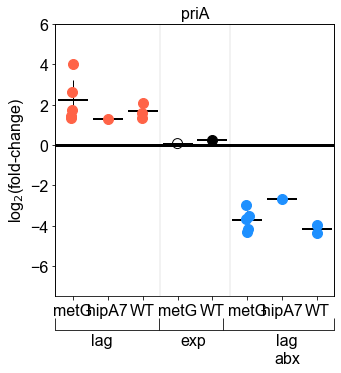

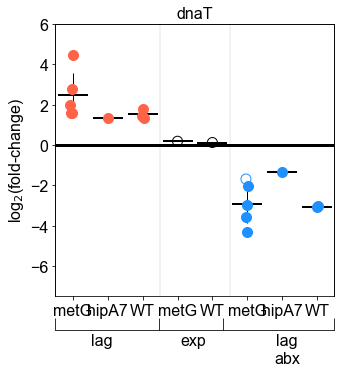

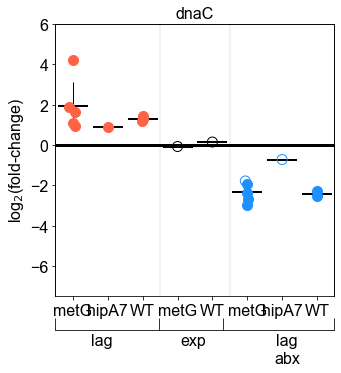

In [4]:
genes = ['b3935=priA','b4362=dnaT','b4361=dnaC']
strand = ['a','s','s']
scatter_errorBar(genes,strand,plot_type='gene',sub_combined='',save=True,prefix='figures/figED10a_',ylim=(-7.5,6))


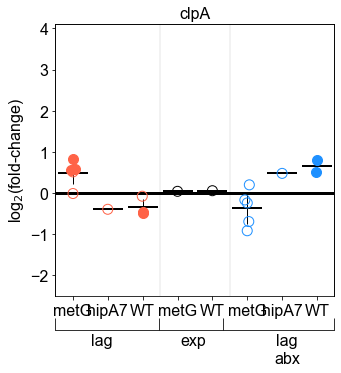

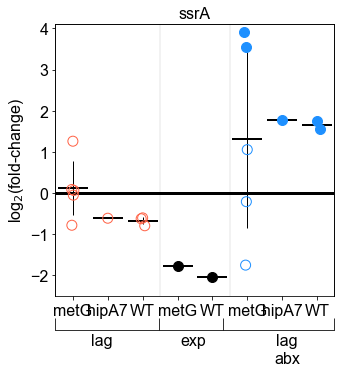

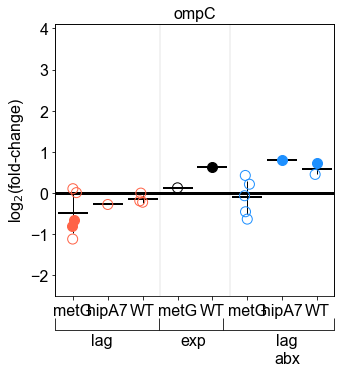

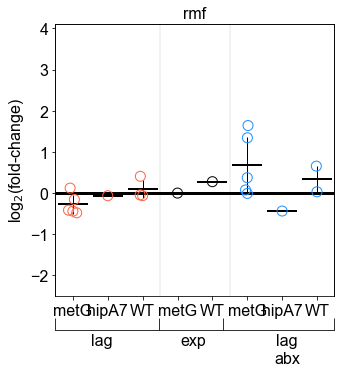

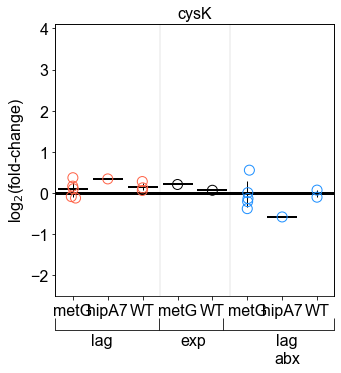

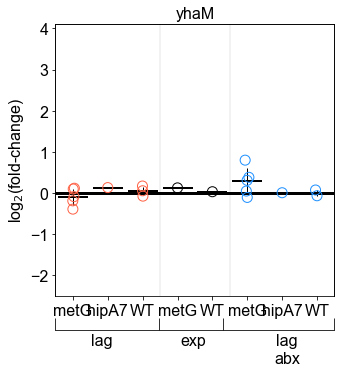

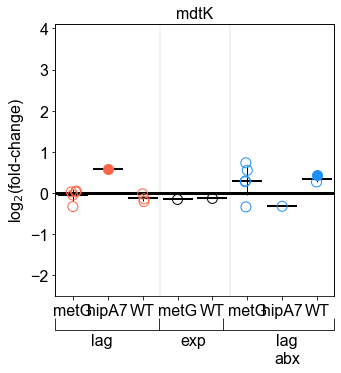

In [5]:
genes = ['b0882=clpA','b2621=ssrA','b2215=ompC','b0953=rmf','b2414=cysK','b4470=yhaM','b1663=mdtK']
strand = ['a','a','a','a','a','a','a']
scatter_errorBar(genes,strand,plot_type='gene',sub_combined='',save=True,prefix='figures/figED10b_',ylim=(-2.5,4.1))


In [6]:
# save files for each replicate for iPAGE
# run iPAGE: discrete, max_p = 0.05
# if 1 of anti-sense or sense is significant, use that one
# if both are significant in opposite directions, use the higher one

for c in combined.columns[combined.columns.str.contains('signif')]:
    l = pd.DataFrame(combined[c])
    l['LAGs'] = combined['LAGs'].str.split('=',expand=True)[0]
    l['strand'] = combined['strand']
    l = l.sort_values(c,ascending=False)
    new_list = l.loc[l.groupby('LAGs')[c].apply(lambda x: x.abs().idxmax())]
    new_list.index = new_list['LAGs']
    new_list = new_list.iloc[:,0].sort_values()+1
    new_list.to_csv('source_data/generated/ipageInput_fig4_' + c + '.txt',sep='\t')


In [7]:
## read in iPAGE results

combined_pvmatrix = pd.read_csv('source_data/included/ipageInput_fig4_pvmatrix_combined.txt',sep='\t',index_col=0)
## clean up dataframe and make parsable ##
combined_pvmatrix['comparison'] = combined_pvmatrix.index.str.split('.txt_PO_',expand=True).droplevel(1).str.replace('ipageInput_fig4_signif_','')
combined_pvmatrix['type'] = combined_pvmatrix.index.str.split('_PO_',expand=True).droplevel(0).str.split('_P.05_PAGE',expand=True).droplevel(1)
combined_pvmatrix = combined_pvmatrix.reset_index().drop('index',axis=1)
for column in ['0','1','2']:
    combined_pvmatrix = combined_pvmatrix.merge(combined_pvmatrix[column].str.split('/',expand=True).rename(columns={0:column+'_pval_enriched',1:column+'_pval_depleted'}).astype(float),left_index=True,right_index=True)
combined_pvmatrix = combined_pvmatrix.drop(['0','1','2'],axis=1)
## resulting combined dataframe gives p-value (from iPAGE) of enrichment or depletion in each gene classification ##
## gene classifications are 0 (significantly under-represented), 1 (unchanged), 2 (significantly over-represented) ##
combined_pvmatrix.index = combined_pvmatrix['comparison']
combined_pvmatrix = combined_pvmatrix.drop('comparison',axis=1)

## define terms enriched in metG lag, MG1655 lag, or both
pval_threshold = np.log10(0.01)

signif_up_matrix = combined_pvmatrix.loc[(combined_pvmatrix['2_pval_enriched']<pval_threshold) & (combined_pvmatrix['0_pval_enriched']>pval_threshold)]
signif_down_matrix = combined_pvmatrix.loc[(combined_pvmatrix['0_pval_enriched']<pval_threshold) & (combined_pvmatrix['2_pval_enriched']>pval_threshold)]

grouped = signif_up_matrix.loc[metG_lag].groupby('GO')['2_pval_enriched'].count()
metG_lag_term_up = grouped[grouped>=4].index

grouped = signif_up_matrix.loc[metG_exp].groupby('GO')['2_pval_enriched'].count()
metG_exp_term_up = grouped[grouped>=1].index

grouped = signif_up_matrix.loc[MG1655_lag].groupby('GO')['2_pval_enriched'].count()
MG1655_lag_term_up = grouped[grouped>=2].index

grouped = signif_up_matrix.loc[MG1655_exp].groupby('GO')['2_pval_enriched'].count()
MG1655_exp_term_up = grouped[grouped>=1].index

grouped = signif_up_matrix.loc[hipA7_lag].groupby('GO')['2_pval_enriched'].count()
hipA7_lag_term_up = grouped[grouped>=1].index

ipage_df = pd.DataFrame(['metG_lag_term_up'] * len(metG_lag_term_up),index=metG_lag_term_up)
ipage_df = ipage_df.merge(pd.DataFrame(['MG1655_lag_term_up'] * len(MG1655_lag_term_up),index=MG1655_lag_term_up),left_index=True,right_index=True,how='outer')
ipage_df = ipage_df.merge(pd.DataFrame(['hipA7_lag_term_up'] * len(hipA7_lag_term_up),index=hipA7_lag_term_up),left_index=True,right_index=True,how='outer')
ipage_df = ipage_df.merge(pd.DataFrame(['metG_exp_term_up'] * len(metG_exp_term_up),index=metG_exp_term_up),left_index=True,right_index=True,how='outer')
ipage_df = ipage_df.merge(pd.DataFrame(['MG1655_exp_term_up'] * len(MG1655_exp_term_up),index=MG1655_exp_term_up),left_index=True,right_index=True,how='outer')

ipage_df.columns = ['metG','wt','hipA7','metG_exp','wt_exp']
ipage_df = ipage_df.notnull().astype(int)


In [8]:
## find common pathway shortening lag for all

ipage_df = ipage_df.loc[(ipage_df[['metG_exp','wt_exp']].sum(axis=1)==0)]
ipage_df.loc[(ipage_df['wt']==1) & (ipage_df['metG']==1) & (ipage_df['hipA7']==1)]


,metG,wt,hipA7,metG_exp,wt_exp
GO,,,,,
GO:0000104 succinate dehydrogenase activity,1,1,1,0,0
GO:0006099 tricarboxylic acid cycle,1,1,1,0,0


In [9]:
to_save = combined_pvmatrix.loc[metG_lag + MG1655_lag + hipA7_lag + metG_exp + MG1655_exp + metG_lag_abx + MG1655_lag_abx + hipA7_lag_abx]
cols = [False] * len(to_save)
for term in ['GO:0006099','GO:0019538','GO:0008652','PurR_Down','GO:0005507','GO:0004812','GO:0006633','GO:0003735']:
    cols = cols | to_save['GO'].str.contains(term)
s_list = []
for c in to_save.index:
    if c in metG_lag:
        s_list.append('metG_lag')
    elif c in MG1655_lag:
        s_list.append('wt_lag')
    elif c in hipA7_lag:
        s_list.append('hipA7_lag')
    if c in metG_lag_abx:
        s_list.append('metG_lag_abx')
    elif c in MG1655_lag_abx:
        s_list.append('wt_lag_abx')
    elif c in hipA7_lag_abx:
        s_list.append('hipA7_lag_abx')
    if c in metG_exp:
        s_list.append('metG_exponential')
    elif c in MG1655_exp:
        s_list.append('wt_exponential')
to_save['sample_type'] = s_list
to_save.loc[cols,['sample_type','GO','type','0_pval_enriched','2_pval_enriched']].to_csv('source_data/source_tables/figureED10cdef.csv')

In [10]:
## metG* only

genes_df = pd.DataFrame()
for term in ipage_df.loc[(ipage_df['metG']==1)].index:
    full_term = term
    term = term.split(' ')[0]
    genes = []
    for term_type in ['go','tf','sr']:
        ref_file = open('source_data/included/Ecoli_' + term_type + '_index.txt')
        for line in ref_file:
            if term in line:
                genes.append(line.split('\t')[0])
    genes_df = genes_df.merge(pd.DataFrame([1]*len(genes),genes,columns=[full_term]),left_index=True,right_index=True,how='outer')
genes_df = genes_df.fillna(0)
genes_df = genes_df.loc[:,genes_df.sum()[genes_df.sum()>5].index]

## to include: GO:0019538, GO:0006099, GO:0005658 (mostly dnaC,dnaT,priA)
## select pathways that capture at least 5% of genes in any overlapping non-reported pathways

included_pathway_indexes = [4,6,3]
df = pd.DataFrame()
for i in included_pathway_indexes:
    temp_df = pd.DataFrame(genes_df.loc[genes_df.iloc[:,i]>0].sum()/genes_df.sum(),columns=[genes_df.columns[i]])
    df = df.merge(temp_df,how='outer',left_index=True,right_index=True)
df.max(axis=1).sort_values()


ArcA_Up ArcA_Up                                        0.250000
OxDeReD Oxygen Deprivation Response Downregulated      0.302632
AropD ArcAB operon Downregulated                       0.315068
GO:0000104 succinate dehydrogenase activity            0.875000
GO:0005658 alpha DNA polymerase:primase complex        1.000000
GO:0006099 tricarboxylic acid cycle                    1.000000
GO:0006269 DNA replication, synthesis of RNA primer    1.000000
GO:0019538 protein metabolic process                   1.000000
dtype: float64

In [11]:
## hipA7 only

genes_df = pd.DataFrame()
for term in ipage_df.loc[(ipage_df['hipA7']==1)].index:
    full_term = term
    term = term.split(' ')[0]
    genes = []
    for term_type in ['go','tf','sr']:
        ref_file = open('source_data/included/Ecoli_' + term_type + '_index.txt')
        for line in ref_file:
            if term in line:
                genes.append(line.split('\t')[0])
    genes_df = genes_df.merge(pd.DataFrame([1]*len(genes),genes,columns=[full_term]),left_index=True,right_index=True,how='outer')
genes_df = genes_df.fillna(0)
genes_df = genes_df.loc[:,genes_df.sum()[genes_df.sum()>5].index]
genes_df.sum()

## to include: GO:0006099, GO:0005658 (mostly dnaC,dnaT,priA)

## select pathways that capture at least 5% of genes in any overlapping non-reported pathways
included_pathway_indexes = [2,3]
df = pd.DataFrame()
for i in included_pathway_indexes:
    temp_df = pd.DataFrame(genes_df.loc[genes_df.iloc[:,i]>0].sum()/genes_df.sum(),columns=[genes_df.columns[i]])
    df = df.merge(temp_df,how='outer',left_index=True,right_index=True)
df.max(axis=1).sort_values()


FNR_Down FNR_Down                                      0.094737
ArcA_Up ArcA_Up                                        0.153846
GO:0005658 alpha DNA polymerase:primase complex        1.000000
GO:0006099 tricarboxylic acid cycle                    1.000000
GO:0006269 DNA replication, synthesis of RNA primer    1.000000
dtype: float64

22
7


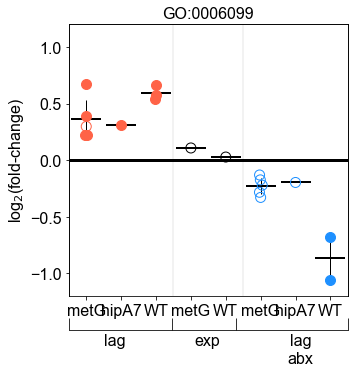

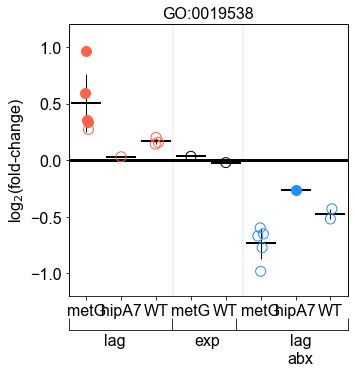

In [12]:
## plot terms selected from ipage

## GO:0008652, GO:0006099, GO:0019538, PurR_Down, GO:0005507
## GO:0005658 is primosome, 3 genes shown individually

## ED10c,d
for (term,term_type) in zip(['GO:0006099','GO:0019538'],['go','go']):
    ## get set of genes in gene set
    bnum_list = []
    term_index = open('source_data/included/Ecoli_' + term_type + '_index.txt')
    for line in term_index:
        if term in line:
            bnum_list.append(line.split('\t')[0])
    bnum_list = pd.Series(bnum_list).unique()
    print(len(bnum_list))
    ## subset full CRISPRi table by genes in gene set; keep more significant (anti-sense/sense)
    ## get mean gene enrichment and significance value for each sample 
    rows = [L.split('=')[0] in bnum_list for L in combined['LAGs']]
    columns = ['signif_' + i for i in metG_lag + hipA7_lag + MG1655_lag]
    order = abs((combined.loc[rows,['strand'] + columns].sort_values('strand')).mean(axis=1)).sort_values(ascending=False).index
    sub_combined = combined.loc[order,].groupby('LAGs').first().mean()
    sub_combined = sub_combined[sub_combined.index.str.contains('enrich')]
    scatter_errorBar(['term=' + term],[''],plot_type='term',sub_combined=sub_combined,save=True,prefix='figures/figED10_',ylim=(-1.2,1.2))


108
31
20


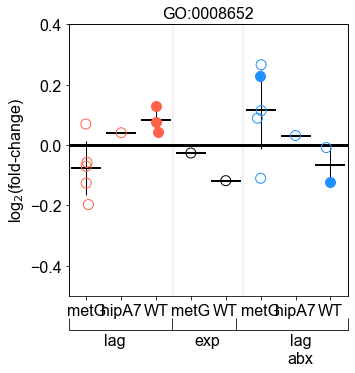

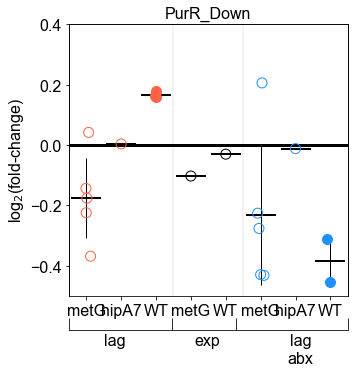

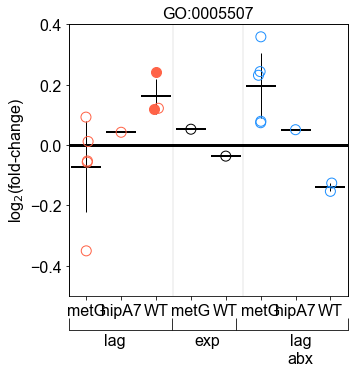

In [13]:
## ED10e
for (term,term_type) in zip(['GO:0008652','PurR_Down','GO:0005507'],['go','tf','go']):
    ## get set of genes in gene set
    bnum_list = []
    term_index = open('source_data/included/Ecoli_' + term_type + '_index.txt')
    for line in term_index:
        if term in line:
            bnum_list.append(line.split('\t')[0])
    bnum_list = pd.Series(bnum_list).unique()
    print(len(bnum_list))
    ## subset full CRISPRi table by genes in gene set; keep more significant (anti-sense/sense)
    ## get mean gene enrichment and significance value for each sample 

    rows = [L.split('=')[0] in bnum_list for L in combined['LAGs']]
    columns = ['signif_' + i for i in metG_lag + hipA7_lag + MG1655_lag]
    order = abs((combined.loc[rows,['strand'] + columns].sort_values('strand')).mean(axis=1)).sort_values(ascending=False).index
    sub_combined = combined.loc[order,].groupby('LAGs').first().mean()
    sub_combined = sub_combined[sub_combined.index.str.contains('enrich')]
    scatter_errorBar(['term=' + term],[''],plot_type='term',sub_combined=sub_combined,save=True,prefix='figures/figED10e_',ylim=(-0.5,0.4))


54
62
11
9
18
26
57


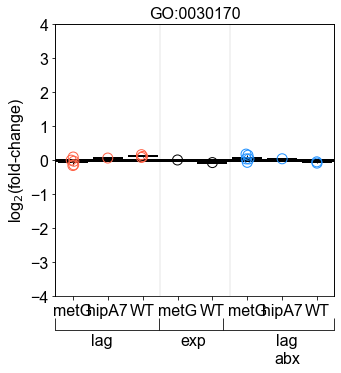

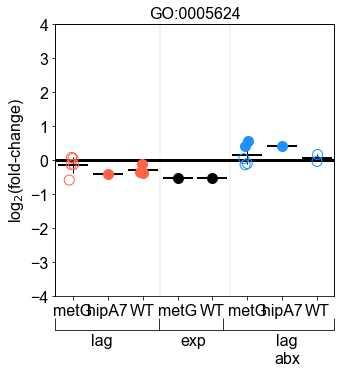

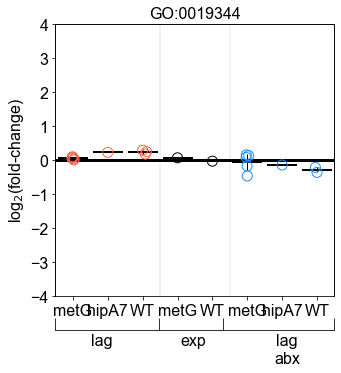

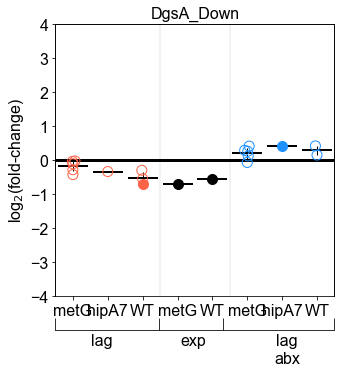

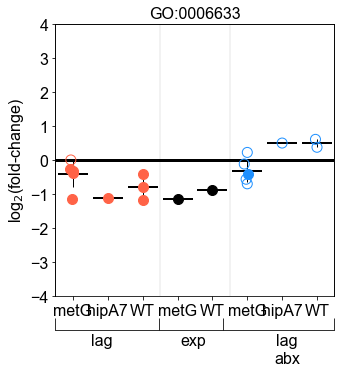

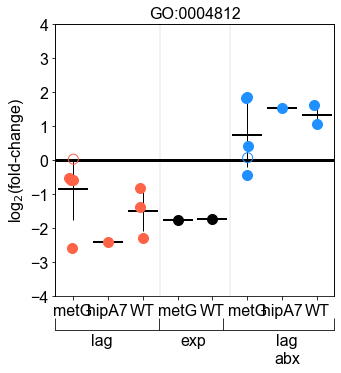

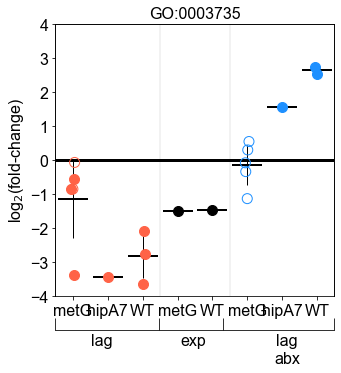

In [14]:
# ED10f
# plot all terms from figure 3/ED9b
# only the three showing significant effects across samples are shown

# [pyridoxal phosphate binding,membrane fraction, cysteine biosynthetic process, DgsA_Down, fatty acid biosynthetic process,aminoacyl-tRNA ligase activity,structural constituent of ribosome]
for (term,term_type) in zip(['GO:0030170','GO:0005624','GO:0019344','DgsA_Down','GO:0006633','GO:0004812','GO:0003735'],['go','go','go','tf','go','go','go']):
    ## get set of genes in gene set
    bnum_list = []
    term_index = open('source_data/included/Ecoli_' + term_type + '_index.txt')
    for line in term_index:
        if term in line:
            bnum_list.append(line.split('\t')[0])
    bnum_list = pd.Series(bnum_list).unique()
    print(len(bnum_list))
    ## subset full CRISPRi table by genes in gene set; keep more significant (anti-sense/sense)
    ## get mean gene enrichment and significance value for each sample 
    rows = [L.split('=')[0] in bnum_list for L in combined['LAGs']]
    columns = ['signif_' + i for i in metG_lag + hipA7_lag + MG1655_lag]
    order = abs((combined.loc[rows,['strand'] + columns].sort_values('strand')).mean(axis=1)).sort_values(ascending=False).index
    sub_combined = combined.loc[order,].groupby('LAGs').first().mean()
    sub_combined = sub_combined[sub_combined.index.str.contains('enrich')]
    scatter_errorBar(['term=' + term],[''],plot_type='term',sub_combined=sub_combined,save=True,prefix='figures/figED10f_',ylim=(-4,4))
